In [1]:
import os
import uuid
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import torch.utils.tensorboard as tensorboard
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data
from torchvision.models.inception import inception_v3
from scipy.stats import entropy
import torch.nn.init as init

import tqdm
import sys
import math
import time
device = 'cuda'

In [2]:
# @title
class STE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, w, bit, symmetric=False):
        '''
        symmetric: True for symmetric quantization, False for asymmetric quantization
        '''
        if bit is None:
            wq = w
        elif bit==0:
            wq = w*0
        else:
            # Build a mask to record position of zero weights
            weight_mask = w != 0

            # Lab3 (a), Your code here:
            if symmetric == False:
                flat_w = w.detach().cpu().numpy().flatten()
                # Compute alpha (scale) for dynamic scaling
                alpha = max(flat_w) - min(flat_w)
                # Compute beta (bias) for dynamic scaling
                beta = min(flat_w)
                # Scale w with alpha and beta so that all elements in ws are between 0 and 1
                ws = (w - beta) / alpha

                step = 2 ** (bit)-1
                # Quantize ws with a linear quantizer to "bit" bits
                R = (1/step) * torch.round(step * ws)
                # Scale the quantized weight R back with alpha and beta
                wq = alpha * R + beta

            # Lab3 (e), Your code here:
            else:
                flat_w = w.detach().cpu().numpy().flatten()

                alpha = np.max(np.abs(flat_w))

                ws = w / alpha

                step = 2 ** (bit - 1) - 1

                R = (1/step) * torch.round(step * ws)

                wq = alpha * R

            # Restore zero elements in wq
            wq = wq*weight_mask

        return wq

    @staticmethod
    def backward(ctx, g):
        return g, None, None

class FP_Linear(nn.Module):
    def __init__(self, in_features, out_features, Nbits=None, symmetric=False):
        super(FP_Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.linear = nn.Linear(in_features, out_features)
        self.Nbits = Nbits
        self.symmetric = symmetric

        # Initailization
        m = self.in_features
        n = self.out_features
        self.linear.weight.data.normal_(0, math.sqrt(2. / (m+n)))

    def forward(self, x):
        return F.linear(x, STE.apply(self.linear.weight, self.Nbits, self.symmetric), self.linear.bias)



class FP_Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=False, Nbits=None, symmetric=False):
        super(FP_Conv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.Nbits = Nbits
        self.symmetric = symmetric

        # Initialization
        n = self.kernel_size * self.kernel_size * self.out_channels
        m = self.kernel_size * self.kernel_size * self.in_channels
        self.conv.weight.data.normal_(0, math.sqrt(2. / (n+m) ))
        self.sparsity = 1.0

    def forward(self, x):
        return F.conv2d(x, STE.apply(self.conv.weight, self.Nbits, self.symmetric), self.conv.bias, self.conv.stride, self.conv.padding, self.conv.dilation, self.conv.groups)



class ResNet_Block(nn.Module):
    def __init__(self, in_chs, out_chs, strides, Nbits=None, symmetric=False):
        super(ResNet_Block, self).__init__()
        self.conv1 = nn.Sequential(
            FP_Conv(in_channels=in_chs, out_channels=out_chs,
                      stride=strides, padding=1, kernel_size=3, bias=False, Nbits=Nbits, symmetric=symmetric),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(True))
        self.conv2 = nn.Sequential(
            FP_Conv(in_channels=out_chs, out_channels=out_chs,
                      stride=1, padding=1, kernel_size=3, bias=False, Nbits=Nbits, symmetric=symmetric),
            nn.BatchNorm2d(out_chs))

        if in_chs != out_chs:
            self.id_mapping = nn.Sequential(
                FP_Conv(in_channels=in_chs, out_channels=out_chs,
                          stride=strides, padding=0, kernel_size=1, bias=False, Nbits=Nbits, symmetric=symmetric),
                nn.BatchNorm2d(out_chs))
        else:
            self.id_mapping = None
        self.final_activation = nn.ReLU(True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        if self.id_mapping is not None:
            x_ = self.id_mapping(x)
        else:
            x_ = x
        return self.final_activation(x_ + out)

class ResNetCIFAR(nn.Module):
    def __init__(self, num_layers=20, Nbits=None, symmetric=False):
        super(ResNetCIFAR, self).__init__()
        self.num_layers = num_layers
        self.head_conv = nn.Sequential(
            FP_Conv(in_channels=3, out_channels=16,
                      stride=1, padding=1, kernel_size=3, bias=False, Nbits=None, symmetric=symmetric),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )
        num_layers_per_stage = (num_layers - 2) // 6
        self.body_op = []
        num_inputs = 16
        # Stage 1
        for j in range(num_layers_per_stage):
            strides = 1
            self.body_op.append(ResNet_Block(num_inputs, 16, strides, Nbits=Nbits, symmetric=symmetric))
            num_inputs = 16
        # Stage 2
        for j in range(num_layers_per_stage):
            if j == 0:
                strides = 2
            else:
                strides = 1
            self.body_op.append(ResNet_Block(num_inputs, 32, strides, Nbits=Nbits, symmetric=symmetric))
            num_inputs = 32
        # Stage 2
        for j in range(num_layers_per_stage):
            if j == 0:
                strides = 2
            else:
                strides = 1
            self.body_op.append(ResNet_Block(num_inputs, 64, strides, Nbits=Nbits, symmetric=symmetric))
            num_inputs = 64

        self.body_op = nn.Sequential(*self.body_op)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.final_fc = FP_Linear(64, 10, Nbits=None)

    def forward(self, x):
        out = self.head_conv(x)
        out = self.body_op(out)
        self.features = self.avg_pool(out)
        self.feat_1d = self.features.mean(3).mean(2)
        return self.final_fc(self.feat_1d)

def test(net):
    transform_test = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((.5, .5, .5), (.5, .5, .5)),
    ])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    criterion = nn.CrossEntropyLoss()

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test accuracy=%.4f" % (test_loss / (num_val_steps), val_acc))
def finetune(net, epochs, batch_size, lr, reg, log_every_n=50):
    print('==> Preparing data..')
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((.5, .5, .5), (.5, .5, .5))

    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((.5, .5, .5), (.5, .5, .5))

    ])
    best_acc = 0  # best test accuracy
    start_epoch = 0  # start from epoch 0 or last checkpoint epoch
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=16)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    net = net.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.875, weight_decay=reg, nesterov=False)

    global_steps = 0
    start = time.time()

    for epoch in range(start_epoch, epochs):
        """
        Start the training code.
        """
        print('\nEpoch: %d' % epoch)
        net.train()
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            global_steps += 1

            if global_steps % log_every_n == 0:
                end = time.time()
                num_examples_per_second = log_every_n * batch_size / (end - start)
                print("[Step=%d]\tLoss=%.4f\tacc=%.4f\t%.1f examples/second"
                      % (global_steps, train_loss / (batch_idx + 1), (correct / total), num_examples_per_second))
                start = time.time()
        """
        Start the testing code.
        """
        net.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        num_val_steps = len(testloader)
        val_acc = correct / total
        print("Test Loss=%.4f, Test acc=%.4f" % (test_loss / (num_val_steps), val_acc))

        if val_acc > best_acc:
            best_acc = val_acc
            print("Saving...")
            torch.save(net.state_dict(), "quantized_net_after_finetune.pt")

In [3]:
C = ResNetCIFAR(num_layers=20, Nbits=None, symmetric=False)
C = C.to(device)
C.load_state_dict(torch.load('finetune.pt'))
test(C)
C.eval()

100%|██████████| 170498071/170498071 [00:03<00:00, 49087324.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Test Loss=0.3248, Test accuracy=0.9151


ResNetCIFAR(
  (head_conv): Sequential(
    (0): FP_Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (body_op): Sequential(
    (0): ResNet_Block(
      (conv1): Sequential(
        (0): FP_Conv(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): FP_Conv(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (final_activation): ReLU(inplace=True)
    )
    (1): ResNet_Block(
      (conv1): Sequential(
        (0): FP_Conv(
         

In [4]:
# Define the critic (discriminator) and generator networks
class Critic(nn.Module):
    def __init__(self, channels_img, features):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            # Input: N x channels_img x 32 x 32
            nn.Conv2d(channels_img, features, kernel_size=4, stride=2, padding=1),  # Output: 16x16
            nn.LeakyReLU(0.2),
            self._block(features, features * 2, 4, 2, 1),  # Output: 8x8
            self._block(features * 2, features * 4, 4, 2, 1),  # Output: 4x4
            self._block(features * 4, features * 8, 4, 2, 1),  # 4x4
            nn.Conv2d(features * 8, 1, kernel_size=2, stride=2, padding=0),  # 1x1
        )
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.critic(x)
    def init_weights(self, m):
      if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.normal_(m.weight, mean=0, std=0.02)
        if m.bias is not None:
            init.zeros_(m.bias)

class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=110, out_features=384*4*4),
            nn.ReLU(inplace=True),

            Reshape((-1, 384, 4, 4)),

            nn.ConvTranspose2d(in_channels=384, out_channels=192, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=192, out_channels=96, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=96, out_channels=3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )
        self.apply(self.init_weights)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.model(x)

    def init_weights(self, m):
      if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.normal_(m.weight, mean=0, std=0.02)
        if m.bias is not None:
            init.zeros_(m.bias)

def test2():
    N, in_channels, H, W = 100, 3, 32, 32
    x = torch.randn((N, in_channels, H, W))
    critic = Critic(in_channels, 64)
    assert critic(x).shape == (N, 1, 1, 1)
    gen = Generator()
    noise_dim = 110
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W)
    print("Success")

test2()

def save_model_state(model, epoch, filepath):
  state = {
      'state_dict': model.state_dict(),
      'epoch': epoch
  }
  torch.save(state, filepath)

Success


In [5]:
# Hyperparams

# Constants
BATCH_SIZE = 100
IMG_SIZE = 32
CHANNELS_IMG = 3
NOISE_DIM = 110
NUM_EPOCHS = 5
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GRAD_PENALTY = 10

learning_rate = 1e-4

# load data
print("==> Preparing data...")

data_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=data_transforms)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

==> Preparing data...
Files already downloaded and verified


In [6]:
# @title
# enforce lipschitz constraint
def gradient_penalty(critic, real, fake, device="cpu"):
    if real.shape != fake.shape:
        print(f'real: {real.shape}')
        print(f'fake: {fake.shape}')

    batch_size, c, h, w = real.shape
    epsilon = torch.rand((batch_size, 1, 1, 1)).repeat(1, c, h, w).to(device)
    interpolated_images = real * epsilon + fake * (1 - epsilon)

    # calculate critic scores
    mixed_scores = critic(interpolated_images)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [7]:
# @title
# Create random noise + fake labels
def create_random_seeding():
  batch_tensors = []
  labels = []
  for _ in range(100):
      random_part = torch.normal(mean=0, std = 1, size = (100, 1, 1)) # better to use uniform random or normal random?
      one_hot_vector = torch.zeros(10, 1, 1)
      label = torch.randint(0, 10, (1,))
      labels.append(label)
      one_hot_vector[label] = 1
      complete_tensor = torch.cat((random_part, one_hot_vector), dim=0)
      batch_tensors.append(complete_tensor)

  final_tensor = torch.stack(batch_tensors)

  return final_tensor.clone().detach().requires_grad_(True), torch.tensor(labels)

def create_sample_seeding() -> torch.Tensor:
  batch_tensors = []
  for i in range(20):
      random_part = torch.normal(mean=0, std = 1, size = (100, 1, 1)) # better to use uniform random or normal random?
      one_hot_vector = torch.zeros(10, 1, 1)
      label = i % 10
      one_hot_vector[label] = 1
      complete_tensor = torch.cat((random_part, one_hot_vector), dim=0)
      batch_tensors.append(complete_tensor)

  final_tensor = torch.stack(batch_tensors)
  return final_tensor

def get_class_accuracies(class_labels, class_predictions):
  correct = 0
  for y, y_hat in zip(class_labels, class_predictions):
    if y == y_hat.argmax(dim = -1):
      correct += 1
  return correct / len(class_labels)

def sample_images(netG, save=False, epoch=0):
  seeds = create_sample_seeding()
  seeds = seeds.to(device)
  netG.eval()
  with torch.no_grad():
    imgs = netG(seeds)

  imgs = imgs / 2 + .5
  grid = torchvision.utils.make_grid(imgs, nrow=10, padding = 4)
  grid = grid.detach().cpu().numpy()
  plt.imshow(np.transpose(grid, (1,2,0)))
  plt.xticks([])
  plt.yticks([])
  if save:
    plt.savefig(f"img_e{epoch}.png")
    np.save(f"grid_e{epoch}.npy", imgs.detach().cpu().numpy())
  else:
    plt.show()

training...: 500it [01:57,  4.26it/s]
[0/500]
G_Loss=4.5731 D_Loss=0.3668
Classification Acc. (R)=0.0000 (F)=0.1019
training...: 500it [01:56,  4.29it/s]
[1/500]
G_Loss=3.7840 D_Loss=-0.0013
Classification Acc. (R)=0.0000 (F)=0.1010
training...: 500it [01:57,  4.24it/s]
[2/500]
G_Loss=2.1297 D_Loss=0.0101
Classification Acc. (R)=0.0000 (F)=0.1003
training...: 500it [01:56,  4.30it/s]
[3/500]
G_Loss=1.5040 D_Loss=-0.2143
Classification Acc. (R)=0.0000 (F)=0.1043
training...: 500it [01:56,  4.29it/s]
[4/500]
G_Loss=0.5894 D_Loss=-0.8697
Classification Acc. (R)=0.0000 (F)=0.1016
training...: 500it [01:57,  4.27it/s]
[5/500]
G_Loss=-0.3589 D_Loss=-1.5102
Classification Acc. (R)=0.0000 (F)=0.1058
training...: 500it [01:57,  4.27it/s]
[6/500]
G_Loss=-0.9969 D_Loss=-1.3056
Classification Acc. (R)=0.0000 (F)=0.1119
training...: 500it [01:56,  4.29it/s]
[7/500]
G_Loss=-3.6455 D_Loss=-1.1963
Classification Acc. (R)=0.0000 (F)=0.1208
training...: 500it [01:56,  4.28it/s]
[8/500]
G_Loss=-4.5839 D_

KeyboardInterrupt: ignored

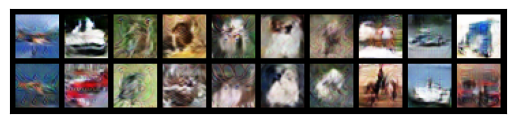

In [8]:
# initialize model
device = "cuda" if torch.cuda.is_available() else "cpu"

gen = Generator().to(device)
critic = Critic(CHANNELS_IMG, FEATURES_CRITIC).to(device)

opt_gen = optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_critic = optim.Adam(critic.parameters(), lr=learning_rate, betas=(0.5, 0.999))

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)

# Training loop
class_criterion = nn.NLLLoss().to(device)

NUM_EPOCHS = 500

D_acc_real, D_acc_fake, D_loss, G_loss = [], [], [], []
D_c_acc_real, D_c_acc_fake = [], []

for epoch in range(NUM_EPOCHS):
  D_loss_temp, G_loss_temp = [], []
  D_c_acc_real_temp, D_c_acc_fake_temp = [], []
  gen.train()
  critic.train()
  for i, (real, real_labels) in tqdm.tqdm(enumerate(loader), desc='training...', file=sys.stdout):
  # for real, real_labels in loader:
    real = real.to(device)
    real_labels = real_labels.to(device)
    for _ in range(CRITIC_ITERATIONS):
      # Generate fake data
      fake_seeding, fake_labels = create_random_seeding()
      fake_seeding = fake_seeding.to(device)
      fake_labels = fake_labels.to(device)
      fake = gen(fake_seeding)
      fake = fake.to(device)

      critic_real = critic(real)
      critic_fake = critic(fake)
      critic_real = critic_real.reshape(-1)
      critic_fake = critic_fake.reshape(-1)

      # D_c_acc_real_temp.append(get_class_accuracies(real_labels, critic_real_prediction))

      grad_penalty = gradient_penalty(critic, real, fake, device=device)
      loss_critic = (
          -(torch.mean(critic_real) - torch.mean(critic_fake))
          + LAMBDA_GRAD_PENALTY * grad_penalty
      )
      critic.zero_grad()
      loss_critic.backward(retain_graph=True)
      opt_critic.step()

      D_loss_temp.append(loss_critic.item())

    # train generator

    c_fake = critic(fake)
    c_fake = c_fake.reshape(-1)
    if i % 5 == 0:
      clz_f = C(fake)
      class_pen = class_criterion(clz_f, fake_labels)
    else:
      class_pen = 0

    loss_gen = -torch.mean(c_fake) + .3 * class_pen
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()
    G_loss_temp.append(loss_gen.item())
    D_c_acc_fake_temp.append(get_class_accuracies(fake_labels, clz_f))
    # D_c_acc_fake_temp.append(1)

  # avg_D_c_acc_real = sum(D_c_acc_real_temp) / len(D_c_acc_real_temp)
  avg_D_c_acc_fake = sum(D_c_acc_fake_temp) / len(D_c_acc_fake_temp)
  avg_D_loss = sum(D_loss_temp) / len(D_loss_temp)
  avg_G_loss = sum(G_loss_temp) / len(G_loss_temp)

  # D_c_acc_real.append(avg_D_c_acc_real)
  D_c_acc_fake.append(avg_D_c_acc_fake)
  D_loss.append(avg_D_loss)
  G_loss.append(avg_G_loss)

  avg_D_c_acc_real = 0
  print("[%d/%d]\nG_Loss=%.4f D_Loss=%.4f\nClassification Acc. (R)=%.4f (F)=%.4f"
        % (epoch, NUM_EPOCHS, avg_G_loss, avg_D_loss, avg_D_c_acc_real, avg_D_c_acc_fake))
  np.save(f"G_loss_{epoch}.npy", G_loss)
  np.save(f"D_loss_{epoch}.npy", D_loss)
  np.save(f"D_c_acc_real_{epoch}.npy", D_c_acc_real)
  np.save(f"D_c_acc_fake_{epoch}.npy", D_c_acc_fake)
  save_model_state(gen, epoch, f"G_{epoch}.pth")
  save_model_state(critic, epoch, f"D_{epoch}.pth")

  sample_images(gen, save=True, epoch=epoch)

In [ ]:
test(C)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
current_dir = '/content'

# List all files in the current directory (excluding folders)
files = [f for f in os.listdir(current_dir) if os.path.isfile(os.path.join(current_dir, f))]

print(len(files))

833


In [11]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/my_fileswec.zip', 'w') as zipf:
    for file in files:
        zipf.write(file)